# Multi-media Information Processing (EECE 7217) 

## Assignment 2

University of Memphis, Spring 2023

Bereket Kebede, Gradaute Student, EECE, U00827234 <br>
For this assignment, we are using a dataset from the UCI machine learning repository. <br>

Instructor: Prof. Michael Bartz

[Reference]

https://github.com/georgetown-analytics/machine-learning/blob/master/notebooks/wheat.ipynb

In [1]:
%matplotlib notebook

import os
import json
import time
import pickle
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt"

def fetch_data(fname='seeds_dataset.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [3]:
FEATURES  = [
    "area",
    "perimeter",
    "compactness",
    "length",
    "width",
    "asymmetry",
    "groove",
    "label"
]

LABEL_MAP = {
    1: "Kama",
    2: "Rosa",
    3: "Canadian",
}

# Read the data into a DataFrame
df = pd.read_csv(DATA, sep='\s+', header=None, names=FEATURES)

# Convert class labels into text
df["label"] = df["label"].map(LABEL_MAP)

# Describe the dataset
print(df.describe())

             area   perimeter  compactness      length       width  \
count  210.000000  210.000000   210.000000  210.000000  210.000000   
mean    14.847524   14.559286     0.870999    5.628533    3.258605   
std      2.909699    1.305959     0.023629    0.443063    0.377714   
min     10.590000   12.410000     0.808100    4.899000    2.630000   
25%     12.270000   13.450000     0.856900    5.262250    2.944000   
50%     14.355000   14.320000     0.873450    5.523500    3.237000   
75%     17.305000   15.715000     0.887775    5.979750    3.561750   
max     21.180000   17.250000     0.918300    6.675000    4.033000   

        asymmetry      groove  
count  210.000000  210.000000  
mean     3.700201    5.408071  
std      1.503557    0.491480  
min      0.765100    4.519000  
25%      2.561500    5.045000  
50%      3.599000    5.223000  
75%      4.768750    5.877000  
max      8.456000    6.550000  


In [4]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(df.groupby('label')['label'].count())

210 instances with 8 features

label
Canadian    70
Kama        70
Rosa        70
Name: label, dtype: int64


In [5]:
from sklearn.preprocessing import LabelEncoder

# Extract our X and y data
X = df[FEATURES[:-1]]
y = df["label"]

# Encode our target variable
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

print(X.shape, y.shape)

(210, 7) (210,)


<IPython.core.display.Javascript object>


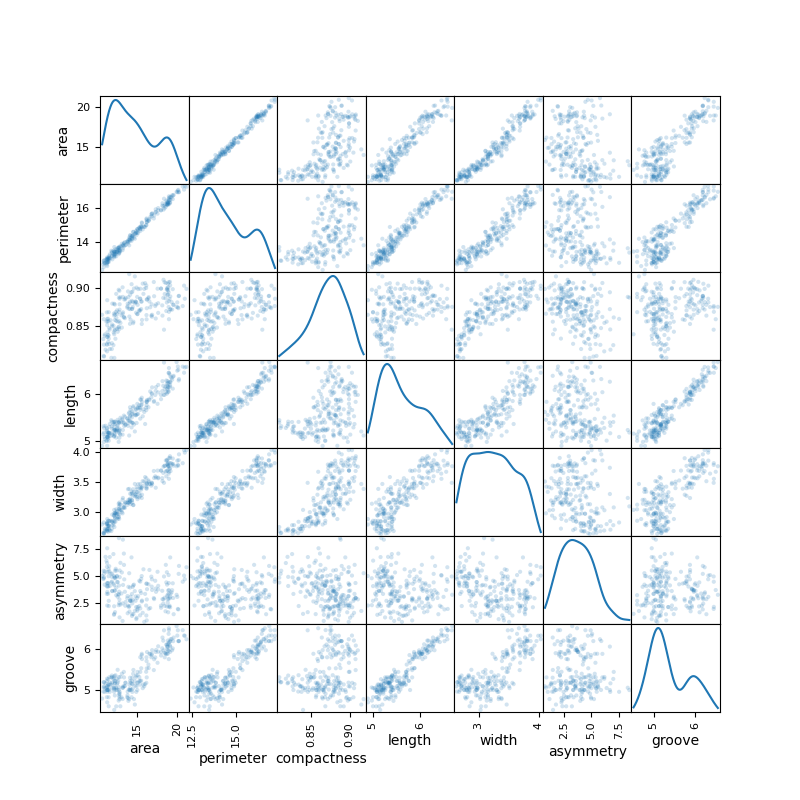

In [7]:
# Create a scatter matrix of the dataframe features
from pandas.plotting import scatter_matrix
scatter_matrix(X, alpha=0.2, figsize=(8, 8), diagonal='kde')
plt.show()

In [12]:
def get_internal_params(model):
    for attr in dir(model):
        if attr.endswith("_") and not attr.startswith("_"):
            print(attr, getattr(model, attr))

In [13]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
model = DecisionTreeClassifier()
model.fit(X,y)
get_internal_params(model)

classes_ [0 1 2]
feature_importances_ [0.34860165 0.00714286 0.         0.03664966 0.00818117 0.06765401
 0.53177066]
feature_names_in_ ['area' 'perimeter' 'compactness' 'length' 'width' 'asymmetry' 'groove']
max_features_ 7
n_classes_ 3
n_features_ 7
n_features_in_ 7
n_outputs_ 1
tree_ <sklearn.tree._tree.Tree object at 0x0000013BC2079340>


C:\Users\Berek\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X, y)
get_internal_params(model)

classes_ [0 1 2]
coef_ [[-2.10674934  0.97678414  0.29846247  0.1621248   0.45571592  0.49521811
   1.68453426]
 [ 0.04125377  0.59581906  0.12676038  1.2576741   0.25609217 -0.56748313
  -2.81374987]
 [ 2.06549557 -1.5726032  -0.42522285 -1.4197989  -0.7118081   0.07226503
   1.12921561]]
feature_names_in_ ['area' 'perimeter' 'compactness' 'length' 'width' 'asymmetry' 'groove']
intercept_ [ 2.10860848  1.13125939 -3.23986786]
n_features_in_ 7
n_iter_ [100]


C:\Users\Berek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
from sklearn import metrics

from sklearn.model_selection import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [18]:
def fit_and_evaluate(X, y, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    kf = KFold(n_splits = 12, shuffle=True)
    
    for train, test in kf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = model(**kwargs) 
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [19]:
# Perform SVC Classification

fit_and_evaluate(X, y, SVC, "Wheat SVM Classifier", gamma = 'auto')

Build and Validation of Wheat SVM Classifier took 0.079 seconds
Validation scores are as follows:

precision    0.915959
recall       0.904956
accuracy     0.904956
f1           0.905360
dtype: float64

Fitted model written to:
C:\Users\Berek\Documents\Graduate School\Spring 2023\Multimedia\Wheat Seeds\wheat-svm-classifier.pickle


In [20]:
# Perform kNN Classification
fit_and_evaluate(X, y, KNeighborsClassifier, "Wheat kNN Classifier", n_neighbors=12)

Build and Validation of Wheat kNN Classifier took 0.068 seconds
Validation scores are as follows:

precision    0.927615
recall       0.910131
accuracy     0.910131
f1           0.910130
dtype: float64

Fitted model written to:
C:\Users\Berek\Documents\Graduate School\Spring 2023\Multimedia\Wheat Seeds\wheat-knn-classifier.pickle


C:\Users\Berek\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Berek\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [21]:
# Perform Random Forest Classification
fit_and_evaluate(X, y, RandomForestClassifier, "Wheat Random Forest Classifier")

Build and Validation of Wheat Random Forest Classifier took 0.970 seconds
Validation scores are as follows:

precision    0.943278
recall       0.928649
accuracy     0.928649
f1           0.928460
dtype: float64

Fitted model written to:
C:\Users\Berek\Documents\Graduate School\Spring 2023\Multimedia\Wheat Seeds\wheat-random-forest-classifier.pickle
